In [1]:
from cmath import nan
from timeit import repeat
from tkinter import Y

import numpy as np
import skimage
from skimage.io import imread
from skimage.measure import block_reduce
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import pickle
import json
import scipy.io as scio
import pickle
from scipy import signal
from skimage import restoration
import scipy
import statistics
import pandas as pd
from collections import Counter
import csv
from scipy.ndimage import median_filter

from pathlib import Path

In [2]:
# Absolute path to the JSON file
file_path = Path(r'C:/Users/Conor/2Psinapod/2Psinapod/config_widefield.json')

# Load JSON file
with file_path.open('r') as f:
    config = json.load(f)

In [3]:
BASE_PATH = config['RecordingFolder'] # folder with all of the files required to process recording. 
SAVE_PATH = "L:/widefield/"
TIFF_PATH = config['TIFF']
CSV_PATH = config['Triggers'] # name of CSV (assumed to be in the folder given in line above) with the trigger voltages over the recording
CONDITIONS_PATH = config['Conditions'] # name of the CSV (assumed to be in folder given two lines above) with the condition types of each trial (freq, intensity, etc)
TIFF = BASE_PATH + TIFF_PATH

STIMULUS_FRAMERATE = config['TriggerFR'] # framerate of the trigger file
TRIGGER_DELAY_IN_MS = config['TriggerDelay'] # delay between TDT sending a trigger and the stimulus actually happening
RECORDING_FRAMERATE = config['RecordingFR'] # framerate of the fluorescence recording
EPOCH_START_IN_MS = config['EpochStart'] # time to include before trial onset for each epoch
EPOCH_END_IN_MS = config['EpochEnd'] # time to include after trial onset for each epoch
NO_BASELINE_FRAMES = config['BaselineFrames']
ZSCORE_THRESHOLD = config['ZscoreThreshold']
START = config['ResponseStart']
STOP = config['ResponseStop']

In [4]:
def get_onset_frames(stimulus):
    # find the max voltage (this will be the value in the vector when the trigger was sent)
    max_voltage = max(stimulus, key=lambda x:x[1])
    max_voltage = max_voltage[1]

    onset_times = [] # empty list to append our onset frames into
    time_list_index = 0 # counter to keep track of our index in the onset_times list

    # for each frame in the stimulus file
    for stimulus_idx in range(len(stimulus)):
        (time,voltage) = stimulus[stimulus_idx] # unpack the voltage at that timepoint

        if voltage.round() == max_voltage.round(): # if the voltage was our trigger voltage
            if time_list_index == 0: # and if we're at the first index (so there's no previous index to compare with)
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # add the time as an onset time in SECONDS
                time_list_index += 1

            # if we're not at index zero, we need to compare this voltage with the previous saved onset voltage
            # otherwise we save a bunch of voltages as separate triggers because they all match the max voltage
            # but we just want one timepoint per trigger
            elif time/1000 -  onset_times[time_list_index - 1] > 1: 
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # want it in second not millisecond
                time_list_index += 1

    # get the onset times in terms of frames of our fluorescence trace
    onset_frames_at_recording_fr = np.multiply(onset_times,RECORDING_FRAMERATE) # s * f/s = f

    #Remove first three triggers, corresponding to start at frame zero, 
    onset_frames_at_recording_fr = onset_frames_at_recording_fr[3:]

    return onset_frames_at_recording_fr

In [5]:
def threshold_responses(median_zscore_dict):
    thresholded_dict = {key : np.clip(median_zscore_dict[key],a_min=ZSCORE_THRESHOLD,a_max=None) for key in median_zscore_dict}
    return thresholded_dict

In [6]:
def get_max_dict(freq_dict):   

    max_dict = dict.fromkeys(np.unique(conditions[:,0])) 
    
    for freq in freq_dict:

        freq_array = np.empty([len(freq_dict[freq]),25,256,256])

        for rep in range(1,len(freq_dict[freq])):
            freq_array[rep-1,:,:,:] = freq_dict[freq][rep]
        
        avg_array = np.mean(freq_array,axis=0)
        stim_periods = avg_array[START:STOP,:,:]
        max_array = np.max(stim_periods,axis=0)

        max_dict[freq] = max_array
    
    return max_dict

In [7]:
def count_above_half_max(array):
    max_value = max(array)
    count = 0
    

    # Check if any value in the array is above 2
    if not any(value > 1 for value in array):
        return 0

    # Find the index of the maximum value in the array
    max_index = array.argmax()
    
    # Start from the index of the maximum value and iterate downwards
    index = max_index
    while index >= 0 and array[index] >= max_value / 2:
        count += 1
        index -= 1
    
    # Start from the index of the maximum value and iterate upwards
    index = max_index + 1  # Start from the next index
    while index < len(array) and array[index] >= max_value / 2:
        count += 1
        index += 1
    
    return count

In [8]:
def get_bandwidth(max_dict):

    max_array = np.zeros([len(max_dict.keys()),256,256])

    for i, key in enumerate(max_dict.keys()):
        max_array[i,:,:] = max_dict[key]

        
    # max_array[max_array < 2] = 0

    bandwidth = np.zeros_like(max_array[0,:,:])

    for i in range(max_array.shape[1]):
        for j in range(max_array.shape[2]):
            bandwidth[i,j] = count_above_half_max(max_array[:,i,j])


    return bandwidth



In [9]:
FILEPATH = "L:/widefield/ID543_saline/Day 1/ID543_24042024_GCaMP6s_1/"

with open(FILEPATH+"zscore_dict.pkl", 'rb') as f:
    zscore_dict = pickle.load(f)

In [10]:
stimulus = np.genfromtxt(BASE_PATH + CSV_PATH,delimiter=',',skip_header=True) # voltage values of the trigger software over the recording
conditions_mat = scio.loadmat(BASE_PATH + CONDITIONS_PATH) # conditition type of each trial in chronological order
conditions = conditions_mat["stim_data"]
conditions = conditions[3:]  #Remove the first silent stim as this corresponds to frame 0

onset_frames = np.round(get_onset_frames(stimulus))


max_dict = get_max_dict(zscore_dict)

# # Normalize the individual frequency so that they are z-scored relative to all of the pixels for that frequency. 
# # This irons out potential bias in the map from the entire cortex being more responsive to particular frequency ranges. 
for key,value in max_dict.items():
    max_dict[key] = scipy.stats.zscore((np.squeeze(value)),axis=None)

In [71]:
# Fits a Median filter to each frame in the recording.  
def fit_median_filter(video,size):
        for frame in range(len(video)):
                video[frame,:,:] = median_filter(video[frame,:,:],size=size)

        return video

In [11]:
bandwidth[bandwidth == 0] = np.nan
filtered = median_filter(bandwidth,3)
plt.imshow(filtered,cmap=cm.jet)


NameError: name 'bandwidth' is not defined

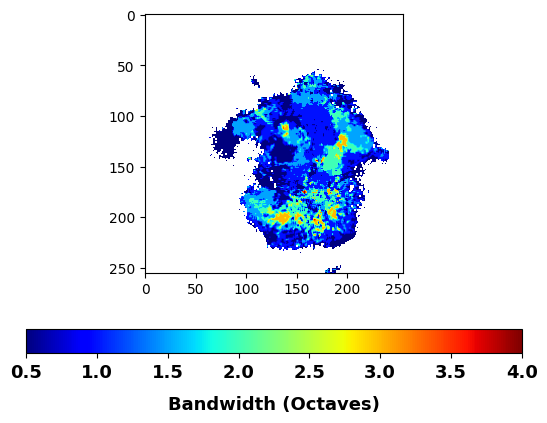

In [88]:
plt.figure()
data = np.squeeze(filtered)
cax = plt.imshow(filtered,cmap=cm.jet)
cbar = plt.colorbar(cax,ticks=[1, 2, 3, 4, 5, 6,7,8],orientation='horizontal')
cbar.ax.set_xticklabels(['0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0'],  fontsize=13,fontweight='bold')  # vertically oriented colorbar
cbar.ax.set_xlabel("Bandwidth (Octaves)",labelpad=10,fontsize=13,fontweight='bold')
plt.show()

In [62]:
#DONT CLICK
bandwidth_all = []

In [79]:
bandwidth = get_bandwidth(max_dict)

bandwidth_flat = bandwidth.flatten()

bandwidth_all.append(bandwidth_flat)

In [64]:
print(len(bandwidth_all))

1


In [98]:
# np.save(SAVE_PATH+'bandwidth_day21_saline.npy',bandwidth_all)

In [21]:
one = np.load(SAVE_PATH+'active_bandwidth_day1_psilocybin.npy')

# one_concat = np.concatenate(one)


two = np.load(SAVE_PATH+'active_bandwidth_day6_psilocybin.npy')

# two_concat = np.concatenate(two)


three = np.load(SAVE_PATH+'active_bandwidth_day14_psilocybin.npy')

# three_concat = np.concatenate(three)


four = np.load(SAVE_PATH+'active_bandwidth_day21_psilocybin.npy')
print(four.shape)

# four_concat = np.concatenate(four)

(142807,)


In [16]:
def calculate_cdf(data):
    # Define your series
    s = pd.Series(data, name = 'value')
    df = pd.DataFrame(s)
    # Get the frequency, PDF and CDF for each value in the series

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    stats_df

    return stats_df

In [17]:
def plot_cdf(pre,post,title,label_1,label_2):
    pre_cdf = calculate_cdf(pre)
    post_cdf = calculate_cdf(post)

    label = [label_1,label_2]

    zipped = zip([pre_cdf,post_cdf], label)

    fig = plt.figure()

    for frame,label in zipped:
        plt.plot(frame['value'], frame['cdf'],label = label )
    plt.title(title,pad=10)
    plt.xticks(range(12), np.arange(0,6,0.5))
    plt.xlabel("Bandwidth (Octaves)")
    plt.ylabel("Cumulative Probability")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def plot_cdf_all_days(one,two,three,four,label_1,label_2,label_3,label_4,title):
    one_cdf = calculate_cdf(one)
    two_cdf = calculate_cdf(two)
    three_cdf = calculate_cdf(three)
    four_cdf = calculate_cdf(four)

    label = [label_1,label_2,label_3,label_4]

    zipped = zip([one_cdf,two_cdf,three_cdf,four_cdf], label)

    fig = plt.figure()

    for frame,label in zipped:
        plt.plot(frame['value'], frame['cdf'],label = label )
    plt.title(title,pad=20,fontsize=14)
    plt.xticks(range(12), np.arange(0,6,0.5),fontsize=13)
    plt.xlabel("Bandwidth (Octaves)",fontsize=14,labelpad=10)
    plt.ylabel("Cumulative Probability",fontsize=14,labelpad=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.yticks(fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

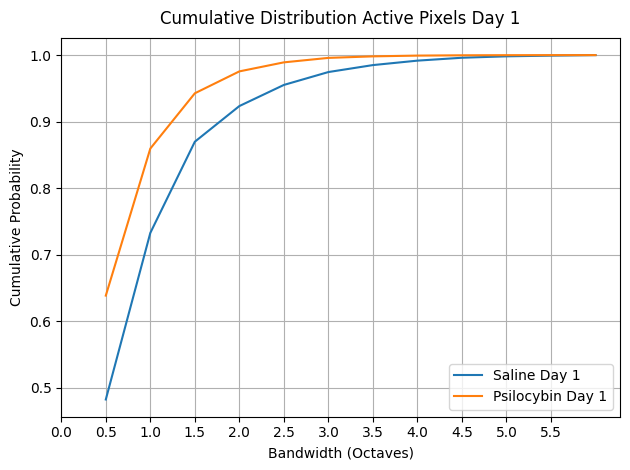

In [22]:
title = 'Cumulative Distribution Active Pixels Day 1'
label_1 = 'Saline Day 1'
label_2 = 'Psilocybin Day 1'

plot_cdf(one,four,title,label_1,label_2)

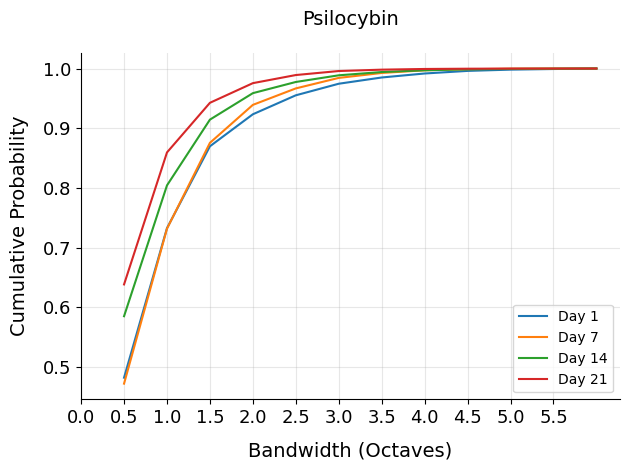

In [24]:
title = 'Psilocybin'
label_1 = 'Day 1'
label_2 = 'Day 7'
label_3 = 'Day 14'
label_4 = 'Day 21'

plot_cdf_all_days(one,two,three,four,label_1,label_2,label_3,label_4,title)

In [29]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(one,two)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 8602197380.5
P-value: 7.402968960488706e-169


In [27]:
plt.imshow(bandwidth)

NameError: name 'bandwidth' is not defined

In [ ]:
'''
How to plot bandwidth changes:

Plot the CDF for the entire cohort?  Combine all pixels into one huge array and their bandwidth. 


'''

In [14]:
bandwidth_flat = bandwidth.flatten()

bandwidth_active = [x for x in bandwidth_flat if x != 0]

print(bandwidth_flat.shape)


(65536,)


Text(0, 0.5, 'Pixel Count')

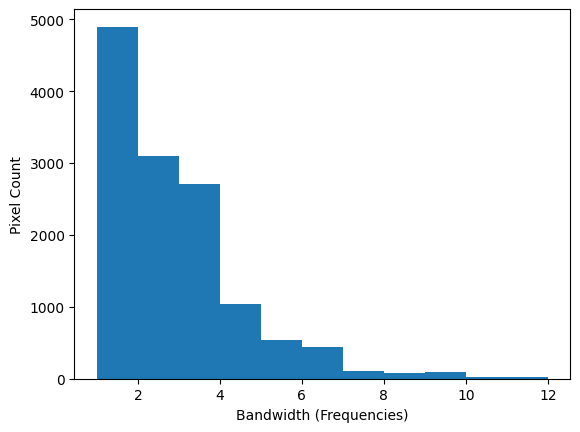

In [15]:
plt.hist(bandwidth_active,bins=11)
plt.xlabel("Bandwidth (Frequencies)")
plt.ylabel("Pixel Count")

In [117]:
def get_active_bandwidths(data):
    active_bandwidths = data[data != 0]
    return active_bandwidths

In [121]:
day_1 = np.load(SAVE_PATH+'bandwidth_day1_psilocybin.npy')
day_6 = np.load(SAVE_PATH+'bandwidth_day6_psilocybin.npy')
day_14 = np.load(SAVE_PATH+'bandwidth_day14_psilocybin.npy')
day_21 = np.load(SAVE_PATH+'bandwidth_day21_psilocybin.npy')

np.save(SAVE_PATH+'active_bandwidth_day1_psilocybin',(get_active_bandwidths(day_1)))
np.save(SAVE_PATH+'active_bandwidth_day6_psilocybin',(get_active_bandwidths(day_6)))
np.save(SAVE_PATH+'active_bandwidth_day14_psilocybin',(get_active_bandwidths(day_14)))
np.save(SAVE_PATH+'active_bandwidth_day21_psilocybin',(get_active_bandwidths(day_21)))

In [ ]:
'''
Alternative approach:

Calculate the percentage of the field of view that has each bandwidth - this allows you to normalize to your day 1 bandwidth



'''

In [94]:
bandwidth_flat = bandwidth.flatten()

bandwidth_active = [x for x in bandwidth_flat if x != 0]

bandwidth_counts_all = Counter(bandwidth_flat)
bandwidth_counts_active = Counter(bandwidth_active)

bandwidth_counts_percent_all = {key: value/(len(bandwidth_flat))*100 for key,value in bandwidth_counts_all.items()}
bandwidth_counts_percent_active = {key: value/(len(bandwidth_active))*100 for key,value in bandwidth_counts_active.items()}


print(bandwidth_counts_percent_all)
print(bandwidth_counts_percent_active)

In [2]:
FILEPATH = "L:/widefield/compiled/"

In [21]:
with open(FILEPATH+"saline_day14.pkl", 'rb') as f:
    saline_day14 = pickle.load(f)

KeyboardInterrupt: 

In [3]:
def get_bandwidth_percentages(zscore_dict):

    bandwidth_array_all = np.zeros([len(zscore_dict.keys()),13]) 
    bandwidth_array_active = np.zeros([len(zscore_dict.keys()),12]) 

    for i,key in enumerate(zscore_dict):
        max_dict = get_max_dict(zscore_dict[key])
        bandwidth_keys = np.arange(0,(len(max_dict.keys())+1),1)

        bandwidth_keys_active = np.arange(1,(len(max_dict.keys())+1),1)
       
        bandwidth = get_bandwidth(max_dict)

        bandwidth_flat = bandwidth.flatten()

        bandwidth_active = [x for x in bandwidth_flat if x != 0]

        bandwidth_counts_all = Counter(bandwidth_flat)
        for key in bandwidth_keys:
            bandwidth_counts_all.setdefault(key, 0)

        bandwidth_counts_active = Counter(bandwidth_active)
        for key in bandwidth_keys_active:
            bandwidth_counts_active.setdefault(key, 0)


        bandwidth_counts_percent_all = {key: value/(len(bandwidth_flat))*100 for key,value in bandwidth_counts_all.items()}
        list_all = list(bandwidth_counts_percent_all.values())
       

        bandwidth_counts_percent_active = {key: value/(len(bandwidth_active))*100 for key,value in bandwidth_counts_active.items()}
        list_active = list(bandwidth_counts_percent_active.values())
    


        bandwidth_array_all[i,:] = list_all
        bandwidth_array_active[i,:] = list_active
        
    return bandwidth_array_all, bandwidth_array_active
        


In [21]:
saline_day14_bandwidth_all, saline_day14_bandwidth_active = get_bandwidth_percentages(saline_day14)

In [5]:
SAVE_PATH = "L:/widefield/bandwidth_percentages/"

In [23]:
np.savetxt(SAVE_PATH + 'saline_day14_all.csv', saline_day14_bandwidth_all, delimiter=',', fmt='%.8f')
np.savetxt(SAVE_PATH + 'saline_day14_active.csv', saline_day14_bandwidth_active, delimiter=',', fmt='%.8f')

In [6]:
saline_day1_active = np.loadtxt(SAVE_PATH+'saline_day1_active.csv', delimiter=',')

saline_day6_active = np.loadtxt(SAVE_PATH+'saline_day6_active.csv', delimiter=',')

saline_day14_active = np.loadtxt(SAVE_PATH+'saline_day14_active.csv', delimiter=',')

saline_day21_active = np.loadtxt(SAVE_PATH+'saline_day21_active.csv', delimiter=',')


psilocybin_day1_active = np.loadtxt(SAVE_PATH+'psilocybin_day1_active.csv', delimiter=',')

psilocybin_day6_active = np.loadtxt(SAVE_PATH+'psilocybin_day6_active.csv', delimiter=',')

psilocybin_day14_active = np.loadtxt(SAVE_PATH+'psilocybin_day14_active.csv', delimiter=',')

psilocybin_day21_active = np.loadtxt(SAVE_PATH+'psilocybin_day21_active.csv', delimiter=',')



In [7]:
def get_mean_and_SE(percentages):

    means = np.mean(percentages, axis=0)
    
    SE = scipy.stats.sem(percentages, axis=0)

    return means, SE

In [8]:
saline_1_6_diff_active = saline_day6_active - saline_day1_active
saline_1_6_diff_active_mean, saline_1_6_diff_active_SEM = get_mean_and_SE(saline_1_6_diff_active)

psilocybin_1_6_diff_active = psilocybin_day6_active - psilocybin_day1_active
psilocybin_1_6_diff_active_mean, psilocybin_1_6_diff_active_SEM = get_mean_and_SE(psilocybin_1_6_diff_active)

saline_1_14_diff_active = saline_day14_active - saline_day1_active
saline_1_14_diff_active_mean, saline_1_14_diff_active_SEM = get_mean_and_SE(saline_1_14_diff_active)

psilocybin_1_14_diff_active = psilocybin_day14_active - psilocybin_day1_active
psilocybin_1_14_diff_active_mean, psilocybin_1_14_diff_active_SEM = get_mean_and_SE(psilocybin_1_14_diff_active)

saline_1_21_diff_active = saline_day21_active - saline_day1_active
saline_1_21_diff_active_mean, saline_1_21_diff_active_SEM = get_mean_and_SE(saline_1_14_diff_active)

psilocybin_1_21_diff_active = psilocybin_day21_active - psilocybin_day1_active
psilocybin_1_21_diff_active_mean, psilocybin_1_21_diff_active_SEM = get_mean_and_SE(psilocybin_1_21_diff_active)


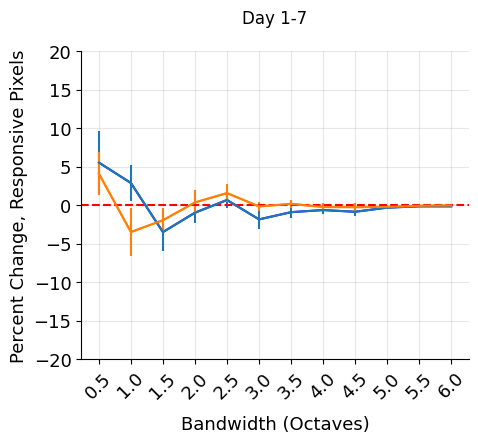

In [22]:
x = np.arange(0,12,1)
plt.figure(figsize=(5,4))
plt.plot(saline_1_6_diff_active_mean,color='b')
plt.errorbar(x,saline_1_6_diff_active_mean,yerr=saline_1_6_diff_active_SEM)
plt.plot(psilocybin_1_6_diff_active_mean,color='orange')
plt.errorbar(x,psilocybin_1_6_diff_active_mean,yerr=psilocybin_1_6_diff_active_SEM)
plt.xticks(x,labels = ['0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'],rotation=45,fontsize=13)
plt.xlabel("Bandwidth (Octaves)",fontsize=13,labelpad=10)
plt.yticks(fontsize=13)
plt.ylabel("Percent Change, Responsive Pixels",fontsize=13)
plt.ylim(-20,20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Day 1-7",pad=20)

plt.grid(alpha=0.3)

In [12]:
print(psilocybin_1_6_diff_active.shape)

(9, 12)


In [45]:
import scipy.stats as stats

data = psilocybin_1_21_diff_active[:,2]

# Conducting the one-sample Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(data - 0, alternative='less')

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The sample median is significantly less than zero.")
else:
    print("Fail to reject the null hypothesis: The sample median is not significantly less than zero.")

print(p_value, statistic)

Fail to reject the null hypothesis: The sample median is not significantly less than zero.
0.064453125 9.0


In [59]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(saline_1_21_diff_active[:,1],psilocybin_1_21_diff_active[:,1])

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 65.0
P-value: 0.034069195144143936
